# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.


### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Apr  7 14:37:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

In [3]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [4]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [5]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [25]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

# Разделим данные на тренировочную и валидационную выборки
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [9]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
loaders = {
    "train": train_dataloader,
    "valid": val_dataloader
}

Давайте посмотрим на наших героев внутри датасета.

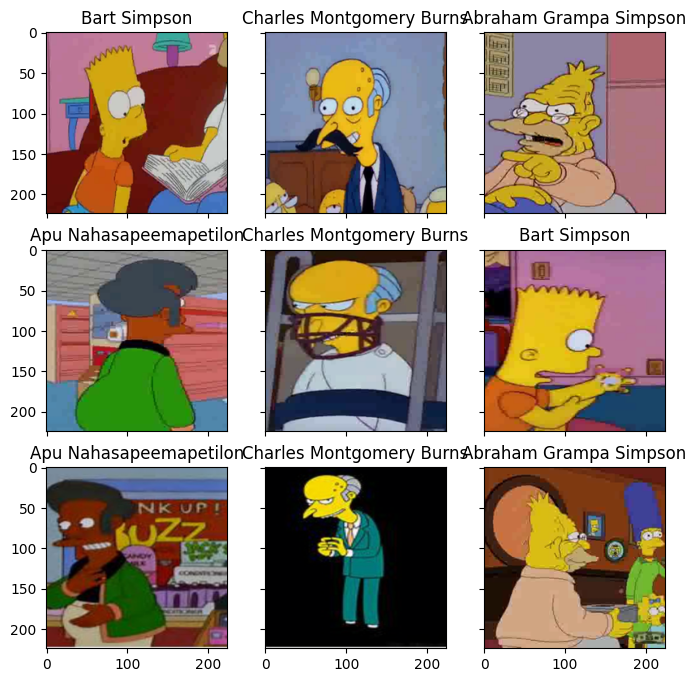

In [26]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Посмотрим сколько у нас всего классов

In [11]:
n_classes = len(np.unique(train_val_labels))
print(n_classes)

42


### Построение нейросети

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

В качестве нейросети возьмем за основу популярнуй сеть Resnet50, изменим в ней последний слой и обучим на наших данных

In [14]:
models.resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [17]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=2
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=2
    )

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        optimizer  = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [18]:
def predict(model, test_loader):
    with torch.inference_mode():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=1024, out_features=512, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=512, out_features=42, bias=True)
    )

In [27]:
epochs=20
batch_size=64

history = train(train_dataset, val_dataset, model=model, epochs=epochs, batch_size=batch_size)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.20815619327283005


epoch:   5%|▌         | 1/20 [02:46<52:42, 166.44s/it]


Epoch 001 train_loss: 0.2082     val_loss 0.2474 train_acc 0.9467 val_acc 0.9370
loss 0.15072702835191473


epoch:  10%|█         | 2/20 [05:32<49:49, 166.07s/it]


Epoch 002 train_loss: 0.1507     val_loss 0.2684 train_acc 0.9597 val_acc 0.9341
loss 0.10002535288577187


epoch:  15%|█▌        | 3/20 [08:19<47:13, 166.70s/it]


Epoch 003 train_loss: 0.1000     val_loss 0.1953 train_acc 0.9733 val_acc 0.9520
loss 0.11582028749753347


epoch:  20%|██        | 4/20 [11:05<44:24, 166.50s/it]


Epoch 004 train_loss: 0.1158     val_loss 0.2213 train_acc 0.9685 val_acc 0.9480
loss 0.08030558162301739


epoch:  25%|██▌       | 5/20 [13:52<41:38, 166.57s/it]


Epoch 005 train_loss: 0.0803     val_loss 0.2266 train_acc 0.9792 val_acc 0.9433
loss 0.06336546314239437


epoch:  30%|███       | 6/20 [16:42<39:07, 167.68s/it]


Epoch 006 train_loss: 0.0634     val_loss 0.1954 train_acc 0.9839 val_acc 0.9557
loss 0.054092807408647185


epoch:  35%|███▌      | 7/20 [19:30<36:20, 167.72s/it]


Epoch 007 train_loss: 0.0541     val_loss 0.1763 train_acc 0.9860 val_acc 0.9612
loss 0.04903619480071645


epoch:  40%|████      | 8/20 [22:18<33:34, 167.90s/it]


Epoch 008 train_loss: 0.0490     val_loss 0.2818 train_acc 0.9874 val_acc 0.9431
loss 0.0543554559948345


epoch:  45%|████▌     | 9/20 [25:04<30:40, 167.32s/it]


Epoch 009 train_loss: 0.0544     val_loss 0.1634 train_acc 0.9861 val_acc 0.9647
loss 0.06156191150646858


epoch:  50%|█████     | 10/20 [27:49<27:46, 166.70s/it]


Epoch 010 train_loss: 0.0616     val_loss 0.1598 train_acc 0.9851 val_acc 0.9671
loss 0.02767154795791712


epoch:  55%|█████▌    | 11/20 [30:37<25:02, 166.97s/it]


Epoch 011 train_loss: 0.0277     val_loss 0.2627 train_acc 0.9923 val_acc 0.9415
loss 0.04635776542646808


epoch:  60%|██████    | 12/20 [33:23<22:12, 166.59s/it]


Epoch 012 train_loss: 0.0464     val_loss 0.2252 train_acc 0.9874 val_acc 0.9528
loss 0.05288796783147872


epoch:  65%|██████▌   | 13/20 [36:08<19:23, 166.14s/it]


Epoch 013 train_loss: 0.0529     val_loss 0.1497 train_acc 0.9868 val_acc 0.9729
loss 0.03590014547932305


epoch:  70%|███████   | 14/20 [38:54<16:37, 166.30s/it]


Epoch 014 train_loss: 0.0359     val_loss 0.1837 train_acc 0.9910 val_acc 0.9608
loss 0.0375176502052409


epoch:  75%|███████▌  | 15/20 [41:50<14:05, 169.11s/it]


Epoch 015 train_loss: 0.0375     val_loss 0.2302 train_acc 0.9899 val_acc 0.9568
loss 0.042425491919417156


epoch:  80%|████████  | 16/20 [44:36<11:12, 168.21s/it]


Epoch 016 train_loss: 0.0424     val_loss 0.1812 train_acc 0.9893 val_acc 0.9641
loss 0.02810671238537874


epoch:  85%|████████▌ | 17/20 [47:21<08:21, 167.23s/it]


Epoch 017 train_loss: 0.0281     val_loss 0.2116 train_acc 0.9938 val_acc 0.9545
loss 0.020388489218440713


epoch:  90%|█████████ | 18/20 [50:06<05:33, 166.61s/it]


Epoch 018 train_loss: 0.0204     val_loss 0.2198 train_acc 0.9952 val_acc 0.9620
loss 0.018972282504971176


epoch:  95%|█████████▌| 19/20 [52:51<02:46, 166.09s/it]


Epoch 019 train_loss: 0.0190     val_loss 0.1742 train_acc 0.9952 val_acc 0.9662
loss 0.023396241583743534


epoch: 100%|██████████| 20/20 [55:36<00:00, 166.84s/it]


Epoch 020 train_loss: 0.0234     val_loss 0.1757 train_acc 0.9947 val_acc 0.9658


In [28]:
loss, acc, val_loss, val_acc = zip(*history)

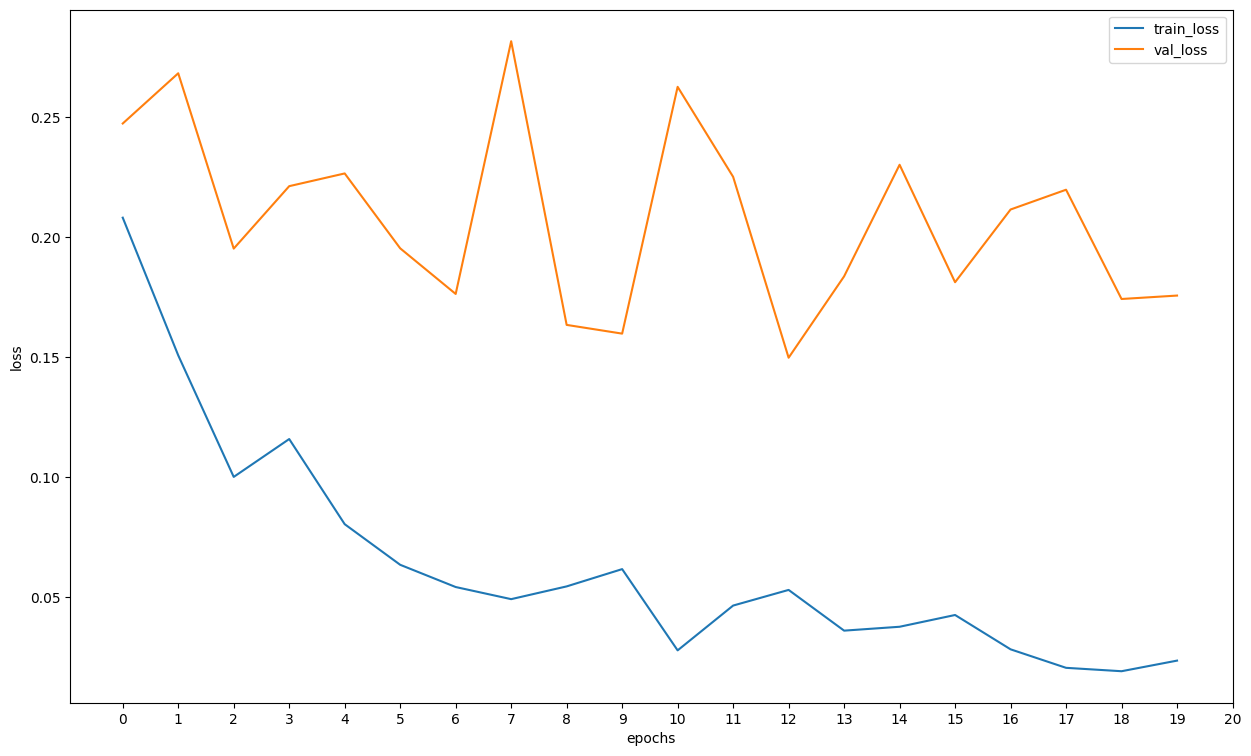

In [29]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.xticks(np.arange(0, epochs + 1, 1))
plt.ylabel("loss")
plt.show()

In [30]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [40]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [41]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [42]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [43]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

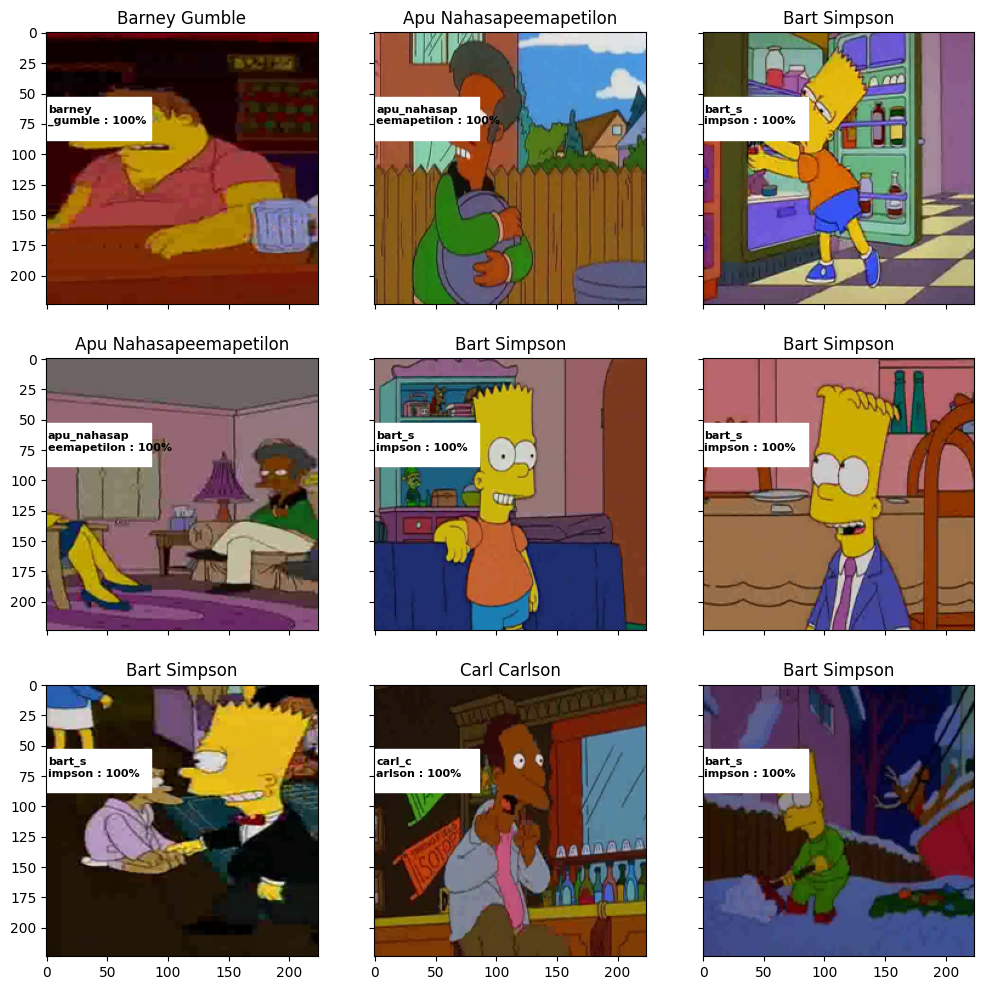

In [38]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [40]:
def save_submit(model, name):
    test_dataset = SimpsonsDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
    probs = predict(model, test_loader)


    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    test_filenames = [path.name for path in test_dataset.files]
    my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
    my_submit.head()
    my_submit.to_csv(name, index=False)

In [41]:
name = 'submission_resnet50_v2.csv'
save_submit(model,name)

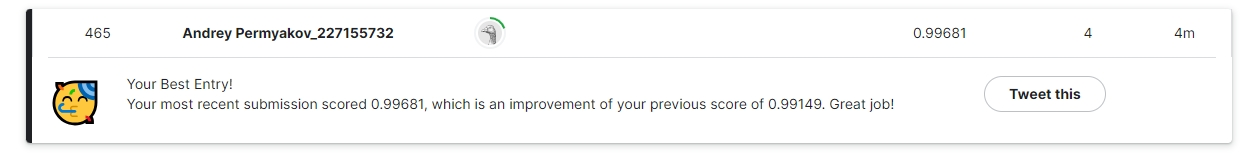